In [361]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from nanonets import Simulation
from matplotlib.colors import Normalize
from scipy.optimize import curve_fit
from scipy.special import gamma

plt.style.use(["science","bright","grid"])

V_WRITES    = [0.01, 0.02, 0.04]
T_WRITES    = [13.9, 1.6, 0.3]
T_WAITS     = [0.1,  0.15,  0.2,  0.3,  0.5,  0.7, 1. ,  1.5 ,  2. ,  3. ,  5. ,  7. , 10. , 15.  , 20. , 30. , 50. , 70. , 100. , 150. , 200. , 300. , 500. , 700. , 1000.]
N_VOLT      = 50000
TIME_STEP   = 1e-11
CMAP        = plt.get_cmap('cividis')
FOLDER      = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/DC/two_steps/"
N_PARTICLES = 9

def stretched_exp(t, tau, beta, I0):
    return I0*np.exp(-(t/tau)**beta)
def exp_decay(t, tau, A):
    return 1 + A*np.exp(-t/tau)
topo = {"Nx": N_PARTICLES,"Ny": N_PARTICLES,
        "e_pos": [[(N_PARTICLES-1)//2, 0],[0, 0],[N_PARTICLES-1, 0],
                [0, (N_PARTICLES-1)//2],[N_PARTICLES-1, (N_PARTICLES-1)//2],
                [0, N_PARTICLES-1],[N_PARTICLES-1, N_PARTICLES-1],[(N_PARTICLES-1)//2, N_PARTICLES-1]],
        "electrode_type": ['constant']*8}
sim_class = Simulation(topo)
cap_mat   = sim_class.get_capacitance_matrix()

In [9]:
def paired_pulse(V_write, t_write, t_wait, dt, N_electrodes=8, input_pos=0):
    
    # Time intervals
    t1_end      = t_write
    t_wait_end  = t_write + t_wait
    t2_end      = t_write + t_wait + t_write

    # Total steps
    n_steps     = int(np.ceil(t2_end / dt))
    t_series    = np.arange(0, n_steps)*dt

    # Voltage Time Series
    V_series        = np.zeros(n_steps)
    pulse1_indices  = t_series < t1_end
    V_series[pulse1_indices] = V_write
    pulse2_indices = (t_series >= t_wait_end) & (t_series < t2_end)
    V_series[pulse2_indices] = V_write

    # Define Input Position
    voltages                = np.zeros((n_steps,N_electrodes+1))
    voltages[:,input_pos]   = V_series

    return t_series, voltages

In [220]:
t   = {V : {t : [paired_pulse(V, t*1e-9, tw*1e-9, TIME_STEP)[0][1:]*1e9 for tw in T_WAITS] for t in T_WRITES} for V in V_WRITES}
x   = {V : {t : [paired_pulse(V, t*1e-9, tw*1e-9, TIME_STEP)[1][1:,0]*1000 for tw in T_WAITS] for t in T_WRITES} for V in V_WRITES}
q   = {V : {t : [pd.read_csv(f"{FOLDER}mean_state_Nx=9_Ny=9_Ne=8_{V:.5f}_{t:.5f}_{tw:.5f}.csv").values*1000 for tw in T_WAITS] for t in T_WRITES} for V in V_WRITES}
# y   = {V : {t : [pd.read_csv(f"{FOLDER}Nx=9_Ny=9_Ne=8_{V:.5f}_{t:.5f}_{tw:.5f}.csv")['Observable'].values*1e-6 for tw in T_WAITS] for t in T_WRITES} for V in V_WRITES}
# y_e = {V : {t : [pd.read_csv(f"{FOLDER}Nx=9_Ny=9_Ne=8_{V:.5f}_{t:.5f}_{tw:.5f}.csv")['Error'].values*1e-6 for tw in T_WAITS] for t in T_WRITES} for V in V_WRITES}

In [353]:
ppr  = {}
taus = np.zeros((len(V_WRITES), len(T_WRITES)))
for n, v_write in enumerate(V_WRITES):
    ppr2 = {}
    for m, t_write in enumerate(T_WRITES):
        lt = []
        for i, t_wait in enumerate(T_WAITS):
            q_vals  = q[v_write][t_write][i].copy()
            idx_w   = np.where(q_vals[:,0] < v_write)[0]
            t1_end  = idx_w[0] - 1
            t2_sta  = idx_w[-1] + 1
            q0  = cap_mat @ q_vals.copy()[0,8:]
            q1  = cap_mat @ q_vals.copy()[t1_end,8:]
            q2  = cap_mat @ q_vals.copy()[t2_sta,8:]
            q3  = cap_mat @ q_vals.copy()[-1,8:]
            R1  = np.linalg.norm(q1 - q0)
            R2  = np.linalg.norm(q3 - q2)
            RV  = R2 / R1
            lt.append(RV)
        ppr2[t_write] = lt
        M_t = 1.0 - np.array(lt)
        M_m = M_t[0]
        r_t = M_t / M_m
        taus[n,m] = np.sum(r_t)
    ppr[v_write] = ppr2

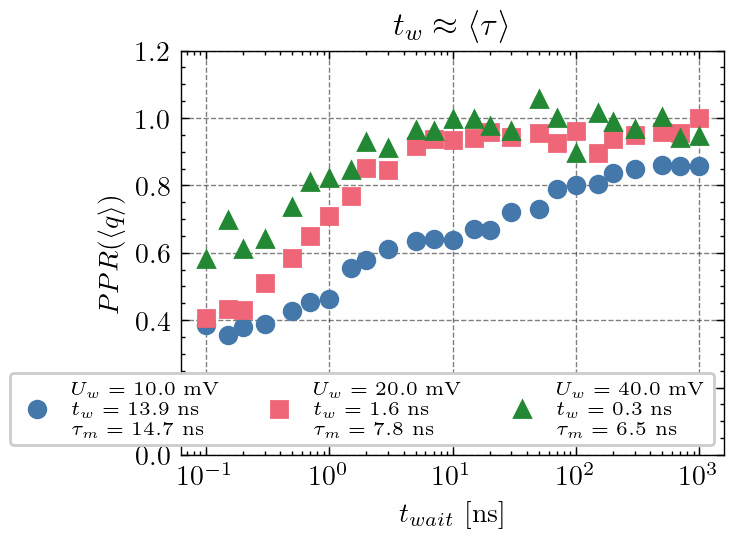

In [ ]:
marker  = ['o','s','^']
fig, ax = plt.subplots(dpi=200)
for i, (v_write, t_write) in enumerate(zip(V_WRITES,T_WRITES)):
    x   = np.array(T_WAITS).copy()
    y   = np.array(ppr[v_write][t_write]).copy()
    pp  = ax.plot(x, y, label=f"$U_w = {v_write*1000}$ mV\n$t_w = {t_write}$ ns\n$\\tau_m = {np.round(taus[i,i],1)}$ ns", marker=marker[i], ls='')
ax.set_xscale('log')
ax.set_ylim(0,1.2)
_ = ax.legend(fontsize='x-small', ncol=3, loc='lower right')
_ = ax.set_ylabel("$PPR(\\langle q \\rangle)$")
_ = ax.set_xlabel("$t_{wait}$ [ns]")
_ = ax.set_title("$t_w \\approx \\langle\\tau\\rangle$")

fig.savefig(f"plots/png/DC/N={N_PARTICLES}_N={N_PARTICLES}_PPR_t2=tau.png", transparent=False)
fig.savefig(f"plots/pdf/DC/N={N_PARTICLES}_N={N_PARTICLES}_PPR_t2=tau.pdf", transparent=False)
fig.savefig(f"plots/svg/DC/N={N_PARTICLES}_N={N_PARTICLES}_PPR_t2=tau.svg", transparent=True)

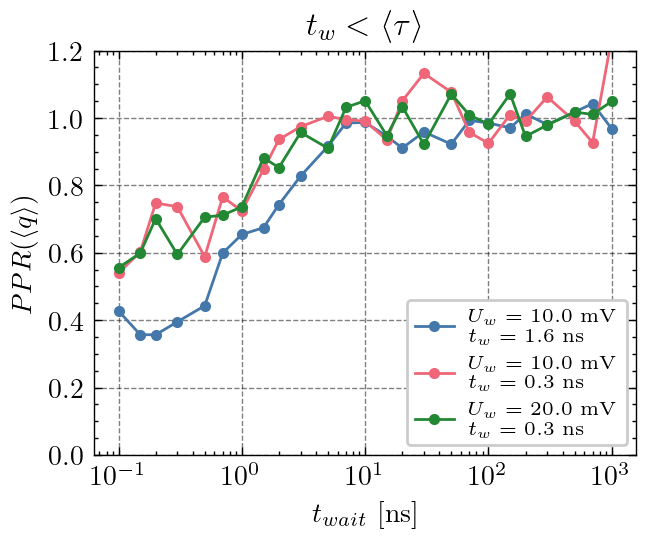

In [330]:
fig, ax = plt.subplots(dpi=200)
for v_write, t_write in [[0.01,1.6],[0.01,0.3],[0.02,0.3]]:
    x       = np.array(T_WAITS).copy()
    y       = np.array(ppr[v_write][t_write]).copy()
    # p, _    = curve_fit(exp_decay, x, y) 
    ax.plot(x, y, label=f"$U_w = {v_write*1000}$ mV\n$t_w = {t_write}$ ns", marker='.')
    # ax.plot(T_WAITS, exp_decay(np.array(T_WAITS), *p))
ax.set_xscale('log')
ax.set_ylim(0,1.2)
_ = ax.legend(fontsize='x-small', ncol=1, loc='lower right')
_ = ax.set_ylabel("$PPR(\\langle q \\rangle)$")
_ = ax.set_xlabel("$t_{wait}$ [ns]")
_ = ax.set_title("$t_w < \\langle\\tau\\rangle$")
fig.savefig(f"plots/png/DC/N={N_PARTICLES}_N={N_PARTICLES}_PPR_t2<tau.png", transparent=False)
fig.savefig(f"plots/pdf/DC/N={N_PARTICLES}_N={N_PARTICLES}_PPR_t2<tau.pdf", transparent=False)
fig.savefig(f"plots/svg/DC/N={N_PARTICLES}_N={N_PARTICLES}_PPR_t2<tau.svg", transparent=True)

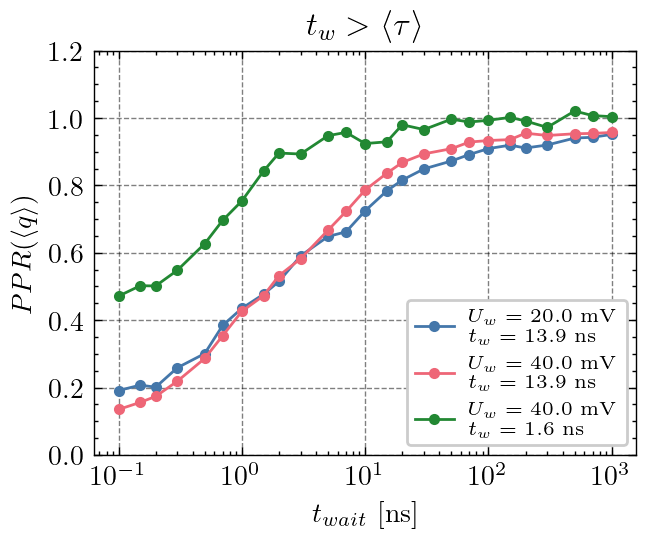

In [327]:
fig, ax = plt.subplots(dpi=200)
for v_write, t_write in [[0.02,13.9],[0.04,13.9],[0.04,1.6]]:
    x       = np.array(T_WAITS).copy()
    y       = np.array(ppr[v_write][t_write]).copy()
    # p, _    = curve_fit(exp_decay, x, y) 
    ax.plot(x, y, label=f"$U_w = {v_write*1000}$ mV\n$t_w = {t_write}$ ns", marker='.')
    # ax.plot(T_WAITS, exp_decay(np.array(T_WAITS), *p))
_ = ax.set_xscale('log')
_ = ax.set_ylim(0,1.2)
_ = ax.legend(fontsize='x-small', ncol=1, loc='lower right')
_ = ax.set_ylabel("$PPR(\\langle q \\rangle)$")
_ = ax.set_xlabel("$t_{wait}$ [ns]")
_ = ax.set_title("$t_w > \\langle\\tau\\rangle$")
fig.savefig(f"plots/png/DC/N={N_PARTICLES}_N={N_PARTICLES}_PPR_t2>tau.png", transparent=False)
fig.savefig(f"plots/pdf/DC/N={N_PARTICLES}_N={N_PARTICLES}_PPR_t2>tau.pdf", transparent=False)
fig.savefig(f"plots/svg/DC/N={N_PARTICLES}_N={N_PARTICLES}_PPR_t2>tau.svg", transparent=True)

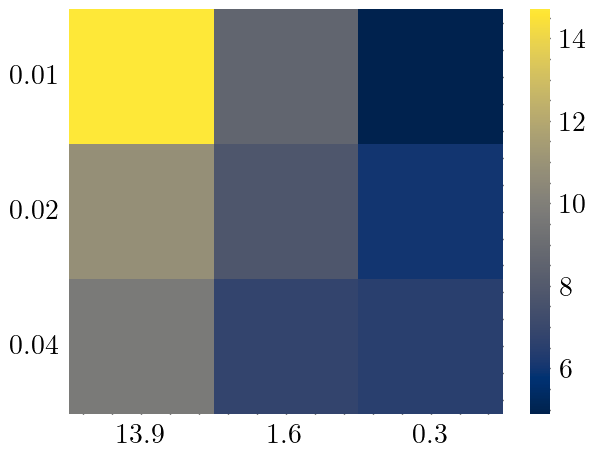

In [384]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.heatmap(np.round(pd.DataFrame(taus, index=V_WRITES, columns=T_WRITES),1), cmap='cividis')
_       = plt.yticks(rotation=0)

In [192]:
ppr = {}
for v_write in V_WRITES:
    ppr2 = {}
    for t_write in T_WRITES:
        lt = []
        for i, t_wait in enumerate(T_WAITS):
            x_vals      = x[v_write][t_write][i].copy()
            if x_vals[-1] != 0:
                t1_end      = np.where(x_vals < v_write*1e3)[0][0]
                t2_start    = np.where(x_vals < v_write*1e3)[0][-1]
            else:
                t1_end      = np.where(x_vals < v_write*1e3)[0][0]
                t2_start    = np.where(x_vals < v_write*1e3)[0][-2]

            I1  = y[v_write][t_write][i].copy()[:t1_end]
            t1  = t[v_write][t_write][i].copy()[:t1_end]
            R1  = np.trapz(I1, t1)
            I2  = y[v_write][t_write][i].copy()[(t2_start+1):]
            t2  = t[v_write][t_write][i].copy()[(t2_start+1):]
            R2  = np.trapz(I2, t2)

            lt.append(R2 / R1)
            # lt.append(I2[-1] / I1[-1])
        ppr2[t_write] = lt
    ppr[v_write] = ppr2

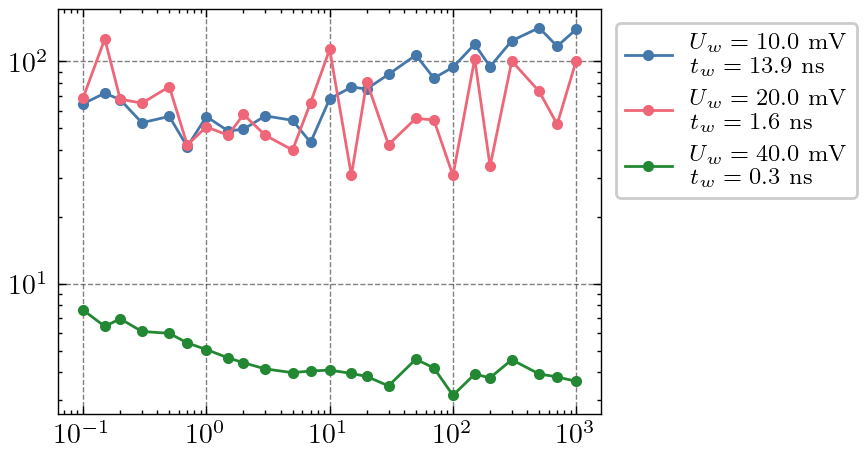

In [219]:
v_write = 0.04
fig, ax = plt.subplots(dpi=200)
for v_write, t_write in zip(V_WRITES,T_WRITES):
    ax.plot(T_WAITS, ppr[v_write][t_write], label=f"$U_w = {v_write*1000}$ mV\n$t_w = {t_write}$ ns", marker='.')
ax.set_xscale('log')
ax.set_yscale('log')
_ = ax.legend(fontsize='small', ncol=1, bbox_to_anchor=[1.25,0.75], loc='center')

(0.0, 42.0)

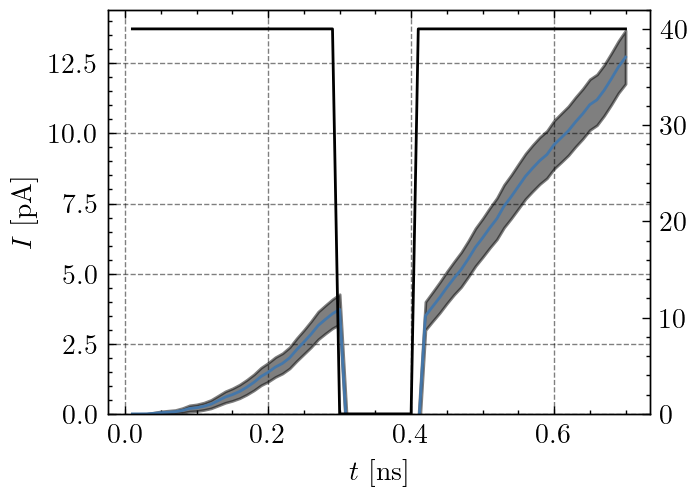

In [208]:
v_write = 0.04
t_write = 0.3
idx     = 0

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(t[v_write][t_write][idx], y[v_write][t_write][idx])
ax.fill_between(t[v_write][t_write][idx], y[v_write][t_write][idx]-y_e[v_write][t_write][idx],
                y[v_write][t_write][idx]+y_e[v_write][t_write][idx], color='black', alpha=0.5)
ax.set_xlabel("$t$ [ns]")
ax.set_ylabel("$I$ [pA]")
ax.set_ylim(0)
# ax.set_yscale('log')
# ax.set_ylim(1e-10)
ax2 = ax.twinx()  
ax2.plot(t[v_write][t_write][idx], x[v_write][t_write][idx], color='black')
ax2.grid(False)
ax2.set_ylim(0)